In [1]:
import tropycal.tracks as tracks
from useful_functions import create_genesis_grid_labels
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage.measure as ms
import scipy.ndimage as nd
from itertools import product

In [2]:
# # Time ranges for EVERYTHING desired
month_range = np.arange(5,13,1).astype(float)
test_years = np.arange(2005,2021,1).astype(float)
train_years = np.arange(1950,2005,1).astype(float)
# train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2).astype(float)
Longitude=np.arange(260,360,2).astype(float)

# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")

In [3]:
train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

# Climatology Plot!

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


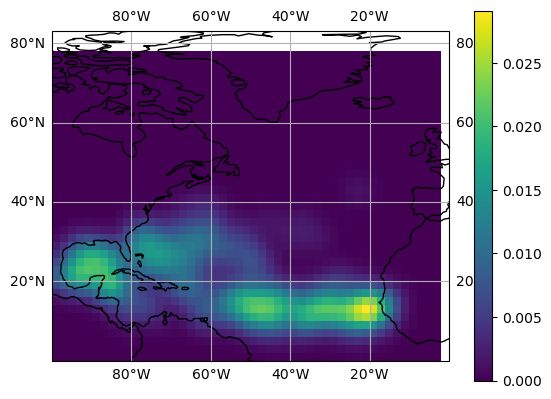

In [4]:
climo_month_label = train_labels_predropped_read.sel(Month=9).to_array()[0]
climo_mean_month_label = np.mean(climo_month_label,axis=2)
climo_filtered_month = gaussian_filter(climo_mean_month_label, sigma=1.5)
climo_filtered_month_with_coords = xr.DataArray(climo_filtered_month, coords=[climo_mean_month_label.coords['Latitude'],climo_mean_month_label.coords['Longitude']])

# Monthly Climatological Plot (Monthly Mean Performed)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
climo_filtered_month_plot = ax.pcolormesh(climo_filtered_month_with_coords.coords['Longitude'],
                                    climo_filtered_month_with_coords.coords['Latitude'],
                                    climo_filtered_month_with_coords,transform=ccrs.PlateCarree(),vmin=0)
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(climo_filtered_month_plot)
plt.savefig('climo')


# Smoothing the climatology indivdual years (temporal and spatial!)

In [19]:
train_canes_use = train_labels_predropped_read["__xarray_dataarray_variable__"]
for yearnow in range(0,len(train_labels_predropped_read.Year)):
    print(yearnow)
    # train_indiv_year_canes = train_canes_use.isel(Year=yearnow)
    # for i, j in product(range(train_canes_use.shape[1]),range(train_canes_use.shape[2])):
    print(train_canes_use[:,:,:,yearnow].astype(float))
        # train_canes_use[:,i,j,yearnow] = gaussian_filter(train_canes_use[:,i,j,yearnow].astype(float),sigma=1)
        # print(gaussian_filter(train_canes_use[:,i,j,yearnow].astype(float),sigma=1))
        # print(train_canes_use[:,i,j,yearnow])
    # print(np.sum(train_canes_use.isel(Year=yearnow)))
        # print(gaussian_filter(train_indiv_year_canes[:,i,j], sigma=0)) # temporal filter
    

0
<xarray.DataArray '__xarray_dataarray_variable__' (Month: 8, Latitude: 40,
                                                   Longitude: 50)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0

(array([8.79161e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        8.35000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

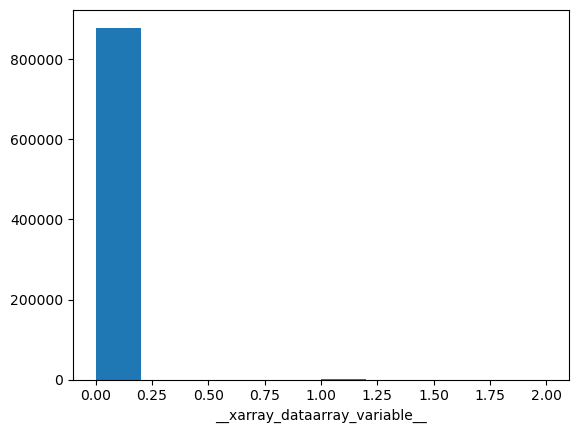

In [15]:
train_canes_use = train_labels_predropped_read["__xarray_dataarray_variable__"]
train_canes_use[:,:,:,:].plot()

In [119]:
gaussian_filter(train_canes_use[:,5,34,yearnow].astype(float),sigma=1)

array([1.33830625e-04, 4.43186162e-03, 5.39911274e-02, 2.41971446e-01,
       3.98943469e-01, 2.41971446e-01, 5.39911274e-02, 4.56569224e-03])

In [125]:
train_canes_use

<xarray.DataArray '__xarray_dataarray_variable__' (Month: 8, Latitude: 40,
                                                   Longitude: 50, Year: 55)>
array([[[[0, ..., 0],
         ...,
         [0, ..., 0]],

        ...,

        [[0, ..., 0],
         ...,
         [0, ..., 0]]],


       ...,


       [[[0, ..., 0],
         ...,
         [0, ..., 0]],

        ...,

        [[0, ..., 0],
         ...,
         [0, ..., 0]]]], dtype=int32)
Coordinates:
  * Year       (Year) float64 1.95e+03 1.951e+03 ... 2.003e+03 2.004e+03
  * Longitude  (Longitude) float64 260.0 262.0 264.0 266.0 ... 354.0 356.0 358.0
  * Latitude   (Latitude) float64 0.0 2.0 4.0 6.0 8.0 ... 72.0 74.0 76.0 78.0
  * Month      (Month) float64 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [214]:
train_indiv_year_canes_use

<xarray.DataArray '__xarray_dataarray_variable__' (Month: 8, Latitude: 40,
                                                   Longitude: 50)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int32)
Coordinates:
    Year       float64 1.963e+03
  * Longitude  (Longitude) float64 260.0 262.0 264.0 266.0 ... 354.0 356.0 358.0
  * Latitude   (Latitude) float64 0.0 2.0 4.0 6.0 8.0 ... 72.0 74.0 76.0 78.0
  * Month      (Month) float64 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [196]:
train_indiv_year_canes_use

<xarray.DataArray '__xarray_dataarray_variable__' (Month: 8, Latitude: 40,
                                                   Longitude: 50)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int32)
Coordinates:
    Year       float64 1.963e+03
  * Longitude  (Longitude) float64 260.0 262.0 264.0 266.0 ... 354.0 356.0 358.0
  * Latitude   (Latitude) float64 0.0 2.0 4.0 6.0 8.0 ... 72.0 74.0 76.0 78.0
  * Month      (Month) float64 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

# Monthly Temporal Smoothing!

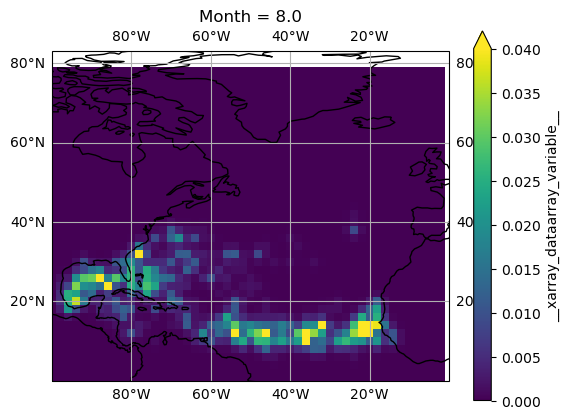

In [148]:
num_years = len(train_labels_predropped_read["Year"]) # what are the number of years?

# sum by month, across all years
sum_canes = train_labels_predropped_read.groupby("Month").sum("Year", skipna=True).astype(float)
# three_sum_canes = xr.concat([sum_canes,sum_canes,sum_canes],dim="Month").astype(float)

Gauss_SmoothAN = sum_canes["__xarray_dataarray_variable__"]/num_years


for i, j in product(range(len(Gauss_SmoothAN[0,:,0])),range(len(Gauss_SmoothAN[0,0,:]))):
    
    Gauss_SmoothAN[:,i,j] = gaussian_filter(Gauss_SmoothAN[:,i,j], sigma=0.5) # temporal filter

# sliced_gauss = Gauss_SmoothAN[len(sum_canes["__xarray_dataarray_variable__"][:,0,0]):
#                               len(sum_canes["__xarray_dataarray_variable__"][:,0,0])*2,:,:]

# gauss_peak_AN = np.argmax(sliced_gauss,axis=0)


plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
for loop in range(1,7):
    Gauss_SmoothAN[loop,:,:] = gaussian_filter(Gauss_SmoothAN[loop,:,:],sigma=0.5) # spatial filter
# plt.pcolormesh(gaussian_filter(sliced_gauss[4], sigma=1.5),vmin=0,vmax=0.05)
Gauss_SmoothAN.isel(Month=3).plot(vmin=0,vmax=0.04)
# plt.colorbar()
# sliced_gauss.isel(Month=5).plot(vmin=0,vmax=0.05)

plt.savefig('climo_double_smoothed.png',dpi=600)

In [150]:
train_labels_predropped_read.isel(Year=4)

<xarray.Dataset>
Dimensions:                        (Longitude: 50, Latitude: 40, Month: 8)
Coordinates:
    Year                           float64 1.954e+03
  * Longitude                      (Longitude) float64 260.0 262.0 ... 358.0
  * Latitude                       (Latitude) float64 0.0 2.0 4.0 ... 76.0 78.0
  * Month                          (Month) float64 5.0 6.0 7.0 ... 11.0 12.0
Data variables:
    __xarray_dataarray_variable__  (Month, Latitude, Longitude) int32 0 0 ... 0

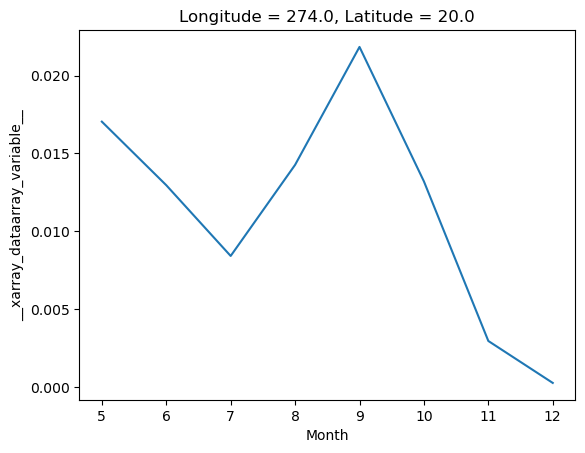

In [127]:
Gauss_SmoothAN[:,10,7].plot()

In [139]:
for loop in range(1,7):
    Gauss_SmoothAN[loop,:,:] = gaussian_filter(Gauss_SmoothAN[loop,:,:],sigma=1)
    
    

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


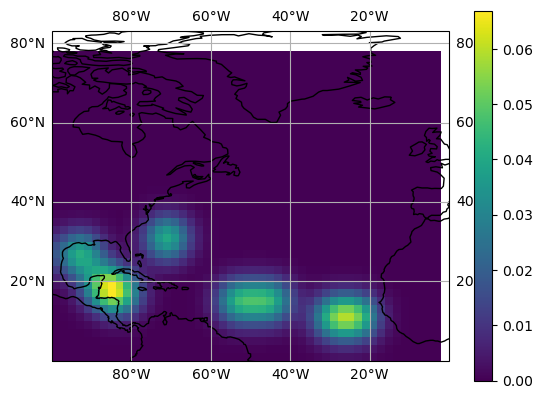

In [26]:
interval = 1 # pooling size (1 is no pooling)

trainlabelpoints_pooled = xr.DataArray(ms.block_reduce(train_labels_predropped_read.to_array()[0], (1,interval,interval,1),np.nansum),
             coords=[train_labels_predropped_read.coords['Month'],
                     train_labels_predropped_read.coords['Latitude'][::interval],
                    train_labels_predropped_read.coords['Longitude'][::interval],
                     train_labels_predropped_read.coords['Year']])

filtered = gaussian_filter(trainlabelpoints_pooled.sel(Month=9,Year=2000).astype(float),sigma=2)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
contourplot = ax.pcolormesh(train_labels_predropped_read.coords['Longitude'][::interval],
                           train_labels_predropped_read.coords['Latitude'][::interval],filtered,transform=ccrs.PlateCarree())
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(contourplot)
plt.savefig('test')
# testlabelpoints_pooled_masked = testlabelpoints_pooled.where(isnan_pool != 0)

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


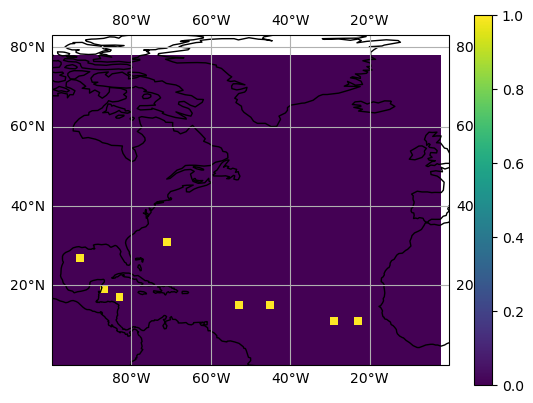

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
contourplot = ax.pcolormesh(train_labels_predropped_read.coords['Longitude'][::interval],
                           train_labels_predropped_read.coords['Latitude'][::interval],
                            train_labels_predropped_read.to_array()[0].sel(Month=9,Year=2000),transform=ccrs.PlateCarree())
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(contourplot)
plt.savefig('gensislocs')